In [76]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.4.4
2.18.0


In [77]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [78]:
# 데이터 경로 수정
train_path = Path(r"C:\Users\user\Downloads\ratings.dat")

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows, engine='python')
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [79]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [80]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [81]:
# UserID를 기준으로 세션 길이(각 사용자의 데이터 개수) 계산
session_length = data.groupby('UserId').size()

# 세션 길이의 기본 통계 확인
print(session_length.describe())


count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64


In [82]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

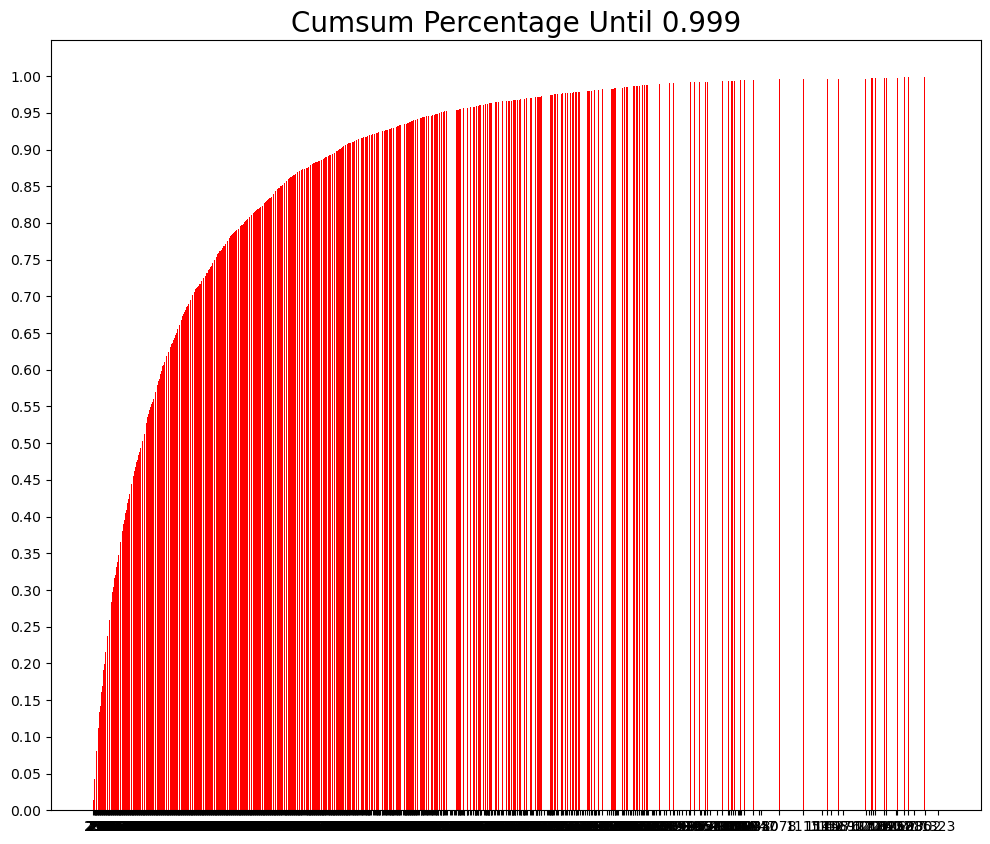

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [84]:
data['datetime'] = pd.to_datetime(data['Time'], unit='s')

# 필요한 시간 요소 추출 및 하나의 열로 병합 (문자열 변환 후 zfill 적용)
data['time_combined'] = (
    data['datetime'].dt.year.astype(str) + '-' +
    data['datetime'].dt.month.astype(str).str.zfill(2) + '-' +
    data['datetime'].dt.day.astype(str).str.zfill(2) + ' ' +
    data['datetime'].dt.hour.astype(str).str.zfill(2) + ':' +
    data['datetime'].dt.minute.astype(str).str.zfill(2)
)

# 결과 확인
print(data[['Time', 'time_combined']].head())

         Time     time_combined
31  978300019  2000-12-31 22:00
22  978300055  2000-12-31 22:00
27  978300055  2000-12-31 22:00
37  978300055  2000-12-31 22:00
24  978300103  2000-12-31 22:01


In [85]:
# 데이터의 시작 및 종료 날짜 확인
start_date = data['datetime'].min()
end_date = data['datetime'].max()

print(f"데이터 수집 기간: {start_date} ~ {end_date}")

데이터 수집 기간: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50


In [86]:
end_date - start_date

Timedelta('1038 days 18:44:18')

In [87]:
data.drop(['Time', 'time_combined'], axis=1, inplace=True)

In [88]:
data

,UserId,ItemId,Rating,datetime
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [89]:
# 결측치 확인
missing_values = data.isnull().sum()
print("결측치 개수:\n", missing_values)

결측치 개수:
 UserId      0
ItemId      0
Rating      0
datetime    0
dtype: int64


In [90]:
# 중복된 행 확인
duplicate_rows = data.duplicated().sum()
print(f"중복된 행 개수: {duplicate_rows}")

중복된 행 개수: 0


In [91]:
# 평점 값의 범위 확인 (1~5 사이여야 함)
print("평점 범위:", data['Rating'].min(), "-", data['Rating'].max())

평점 범위: 1 - 5


In [92]:
# 점수 필터링(1점 제거)
data2 = data[data['Rating'] >= 2]

In [93]:
# from sklearn.model_selection import train_test_split

# # 시간 순으로 정렬
# data = data.sort_values(by='datetime')

# # 분할 인덱스 설정
# train_size = int(0.7 * len(data))
# valid_size = int(0.15 * len(data))

# # 데이터 분할
# train_data = data.iloc[:train_size]
# valid_data = data.iloc[train_size:train_size + valid_size]
# test_data = data.iloc[train_size + valid_size:]

# print(f"Train set size: {len(train_data)} rows")
# print(f"Validation set size: {len(valid_data)} rows")
# print(f"Test set size: {len(test_data)} rows")

In [94]:
from sklearn.model_selection import train_test_split

# 사용자 단위로 train/valid/test 분할
unique_users = data['UserId'].unique()

# 70% train, 30% temp (valid+test)로 분할
train_users, temp_users = train_test_split(unique_users, test_size=0.30, random_state=42)

# 50% valid, 50% test (즉, 전체의 15%씩)
valid_users, test_users = train_test_split(temp_users, test_size=0.50, random_state=42)

# 분할된 사용자 ID 기준으로 데이터 나누기
train_data = data[data['UserId'].isin(train_users)]
valid_data = data[data['UserId'].isin(valid_users)]
test_data = data[data['UserId'].isin(test_users)]

# 결과 확인
print(f"Train set size: {len(train_data)} rows")
print(f"Validation set size: {len(valid_data)} rows")
print(f"Test set size: {len(test_data)} rows")

Train set size: 704889 rows
Validation set size: 150276 rows
Test set size: 145044 rows


In [95]:
# Train, Validation, Test 데이터프레임이 있다고 가정
train_users = set(train_data['UserId'].unique())
valid_users = set(valid_data['UserId'].unique())
test_users = set(test_data['UserId'].unique())

# 교집합 확인
train_valid_overlap = train_users.intersection(valid_users)
train_test_overlap = train_users.intersection(test_users)
valid_test_overlap = valid_users.intersection(test_users)

# 결과 출력
print(f"Train과 Validation의 중복된 사용자 수: {len(train_valid_overlap)}")
print(f"Train과 Test의 중복된 사용자 수: {len(train_test_overlap)}")
print(f"Validation과 Test의 중복된 사용자 수: {len(valid_test_overlap)}")

# 중복 사용자가 없는지 확인
if len(train_valid_overlap) == 0 and len(train_test_overlap) == 0 and len(valid_test_overlap) == 0:
    print("각 데이터 세트 간 UserID가 겹치지 않습니다.")
else:
    print("Warning: 일부 UserID가 여러 세트에 포함되어 있습니다.")

Train과 Validation의 중복된 사용자 수: 0
Train과 Test의 중복된 사용자 수: 0
Validation과 Test의 중복된 사용자 수: 0
각 데이터 세트 간 UserID가 겹치지 않습니다.


In [96]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
all_items = pd.concat([train_data['ItemId'], valid_data['ItemId'], test_data['ItemId']], ignore_index=True).unique()
id2idx = {item_id: index for index, item_id in enumerate(all_items)}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    df = df[df['item_idx'] != -1]  # 유효한 아이템만 유지
    return df

train_data = indexing(train_data, id2idx)
valid_data = indexing(valid_data, id2idx)
test_data = indexing(test_data, id2idx)

In [97]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.data = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.data['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.data['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.data.groupby('UserId').size().cumsum()
        return offsets

In [98]:
tr_dataset = SessionDataset(train_data)
tr_dataset.data.head()

,UserId,ItemId,Rating,datetime,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4


In [99]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 704425, 704548, 704889])

In [100]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4225, 4226, 4227])

In [101]:
# class SessionDataLoader:
#     """Credit to yhs-968/pyGRU4REC."""

#     def __init__(self, dataset: SessionDataset, batch_size=50):
#         self.dataset = dataset
#         self.batch_size = batch_size

#     def __iter__(self):
#         """ Returns the iterator for producing session-parallel training mini-batches.
#         Yields:
#             input (B,):  Item indices that will be encoded as one-hot vectors later.
#             target (B,): a Variable that stores the target item indices
#             masks: Numpy array indicating the positions of the sessions to be terminated
#         """

#         start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
#         """
#         start : Index Where Session Start
#         end : Index Where Session End
#         mask : indicator for the sessions to be terminated
#         """

#         while not finished:
#             min_len = (end - start).min() - 1  # Shortest Length Among Sessions
#             for i in range(min_len):
#                 # Build inputs & targets
#                 inp = self.dataset.df['item_idx'].values[start + i]
#                 target = self.dataset.df['item_idx'].values[start + i + 1]
#                 yield inp, target, mask

#             start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

#     def initialize(self):
#         first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
#         last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
#         start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
#         end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
#         mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
#         finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
#         return start, end, mask, last_session, finished

#     def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
#         # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
#         start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
#         mask = np.arange(self.batch_size)[(end - start) == 1]  
#         # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

#         for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
#             new_session = last_session + i  
#             if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
#                 finished = True
#                 break
#             # update the next starting/ending point
#             start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
#             end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

#         last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
#         return start, end, mask, last_session, finished

In [102]:
class SessionDataLoader:
    """세션 기반 데이터를 배치 단위로 로드하는 데이터로더 클래스."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """
        세션 단위 미니배치를 생성하는 반복자.
        """
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1

        # 인덱스 초과 방지
        first_iters = np.clip(first_iters, 0, len(self.dataset.session_idx) - 1)

        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        mask = np.array([])

        print(f"Total sessions: {len(self.dataset.session_idx)}")
        print(f"First iters max value: {first_iters.max()}")

        while not np.all(first_iters >= len(self.dataset.session_idx)):
            min_len = (end - start).min() - 1  # 가장 짧은 세션 길이
            for i in range(min_len):
                inp = self.dataset.data['ItemId'].values[start + i]
                target = self.dataset.data['ItemId'].values[start + i + 1]
                yield inp, target, mask

            start += min_len
            mask = np.where((end - start) <= 1)[0]

            # 인덱스 초과 방지
            if np.any(last_session + 1 + np.arange(len(mask)) >= len(self.dataset.session_idx)):
                break

            first_iters[mask] = last_session + 1 + np.arange(len(mask))
            last_session += len(mask)

            start[mask] = self.dataset.click_offsets[self.dataset.session_idx[first_iters[mask]]]
            end[mask] = self.dataset.click_offsets[self.dataset.session_idx[first_iters[mask]] + 1]

    def initialize(self):
        """
        배치의 시작과 종료 인덱스를 초기화.
        """
        first_iters = np.arange(self.batch_size)    
        last_session = self.batch_size - 1    
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]     
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  
        mask = np.array([])   
        finished = False         
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        """
        다음 배치 생성을 위한 상태 업데이트.
        """
        start += min_len   
        mask = np.arange(self.batch_size)[(end - start) == 1]  

        for i, idx in enumerate(mask, start=1):  
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  
                finished = True
                break

            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  
        return start, end, mask, last_session, finished


In [103]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size= 4)
tr_dataset.data.head()

,UserId,ItemId,Rating,datetime,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4


In [104]:
iter_ex = iter(tr_data_loader)

In [105]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Total sessions: 4228
First iters max value: 3
Model Input Item Idx are : [3186 1198  593 1210]
Label Item Idx are :       [1270 1210 2858 1097]
Previous Masked Input Idx are []


In [106]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [108]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [109]:
class Args:
    def __init__(self, train_data, valid_data, test_data, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.num_items = train_data['ItemId'].nunique()
        self.num_sessions = train_data['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_data, valid_data, test_data, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [110]:
model = create_model(args)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (2048, 1, 3671)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU (GRU)                       │ [(2048, 50), (2048,    │       558,450 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (2048, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (2048, 3671)           │       187,221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 745,671 (2.84 MB)

 Trainable params: 745,671 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
print(f"최대 ItemId: {args.train_data['ItemId'].max()}, num_items: {args.num_items}")


최대 ItemId: 3952, num_items: 3671


In [112]:
args.num_items = args.train_data['ItemId'].max() + 1


In [113]:
args.num_items = max(
    args.train_data['ItemId'].max(),
    args.valid_data['ItemId'].max(),
    args.test_data['ItemId'].max()
) + 1

print(f"Updated num_items: {args.num_items}")

Updated num_items: 3953


In [114]:
print(f"Updated num_items: {args.num_items}")

Updated num_items: 3953


In [115]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# 학습 함수 (train 데이터로 모델 학습, valid 데이터로 검증)
def train_model(model, args):
    train_dataset = SessionDataset(args.train_data)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train_data) - args.train_data['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)

        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 세션의 상태 초기화

            # 잘못된 아이템 ID가 존재할 수 있으므로 범위를 조정
            feat = np.clip(feat, 0, args.num_items - 1)
            target = np.clip(target, 0, args.num_items - 1)

            # 입력 데이터를 원-핫 인코딩하여 모델에 전달
            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            # 모델 학습
            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])

        # 검증 세트로 평가
        val_recall, val_mrr = get_metrics(args.valid_data, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:.3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:.3f}\n")

# 세션 종료 시 GRU의 히든 상태를 초기화하는 함수
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # 모델에서 GRU 레이어 가져오기
    hidden_states = gru_layer.states[0].numpy()  # GRU의 상태를 numpy 배열로 변환
    for elt in mask:  # 종료된 세션에 대해 히든 스테이트를 초기화
        hidden_states[elt, :] = 0
    gru_layer.reset_states()

# 모델 성능 평가 함수 (Recall@K, MRR@K)
def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        
        # 입력을 원-핫 인코딩 및 차원 확장
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        # 모델 예측 수행
        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # 예측값 정렬 (높은 확률순)

        # 성능 지표 계산
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


In [ ]:
model = create_model(args)  # 모델을 다시 생성
train_model(model, args)    # 모델 훈련 실행

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (2048, 1, 3953)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU (GRU)                       │ [(2048, 50), (2048,    │       600,750 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (2048, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (2048, 3953)           │       201,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802,353 (3.06 MB)

 Trainable params: 802,353 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Train:   0%|          | 0/342 [00:00<?, ?it/s]

Total sessions: 4228
First iters max value: 2047


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

Total sessions: 906
First iters max value: 905
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


Evaluation:   1%|▏         | 1/72 [00:54<1:04:32, 54.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Evaluation:   3%|▎         | 2/72 [01:31<51:29, 44.13s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluation:   4%|▍         | 3/72 [01:50<37:41, 32.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluation:   6%|▌         | 4/72 [02:20<36:01, 31.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Evaluation:   7%|▋         | 5/72 [03:34<52:16, 46.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Evaluation:   8%|▊         | 6/72 [04:54<1:03:51, 58.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Evaluation:  10%|▉         | 7/72 [06:12<1:10:02, 64.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Evaluation:  11%|█         | 8/72 [06:56<1:02:02, 58.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Evaluation:  12%|█▎        | 9/72 [08:03<1:03:58, 60.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Evaluation:  14%|█▍        | 10/72 [09:13<1:05:51, 63.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Evaluation:  15%|█▌        | 11/72 [10:25<1:07:17, 66.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Evaluation:  17%|█▋        | 12/72 [11:41<1:09:03, 69.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluation:  18%|█▊        | 13/72 [12:17<58:18, 59.29s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Evaluation:  19%|█▉        | 14/72 [13:32<1:01:44, 63.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Evaluation:  21%|██        | 15/72 [15:12<1:11:10, 74.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Evaluation:  22%|██▏       | 16/72 [16:28<1:10:06, 75.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Evaluation:  24%|██▎       | 17/72 [17:17<1:01:37, 67.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Evaluation:  25%|██▌       | 18/72 [17:46<50:05, 55.65s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Evaluation:  26%|██▋       | 19/72 [18:26<51:27, 58.25s/it]


	 - Recall@20 epoch 1: 0.149
	 - MRR@20    epoch 1: 0.027



Train:   0%|          | 0/342 [00:00<?, ?it/s]

Total sessions: 4228
First iters max value: 2047


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

Total sessions: 906
First iters max value: 905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Evaluation:   1%|▏         | 1/72 [00:22<27:10, 22.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluation:   3%|▎         | 2/72 [00:43<24:48, 21.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluation:   4%|▍         | 3/72 [01:00<22:25, 19.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluation:   6%|▌         | 4/72 [01:15<20:15, 17.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluation:   7%|▋         | 5/72 [01:31<19:00, 17.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluation:   8%|▊         | 6/72 [01:47<18:23, 16.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluation:  10%|▉         | 7/72 [02:04<18:11, 16.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluation:  11%|█         | 8/72 [02:21<18:09, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluation:  12%|█▎        | 9/72 [02:41<18:37, 17.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluation:  14%|█▍        | 10/72 [03:03<19:55, 19.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluation:  15%|█▌        | 11/72 [03:28<21:22, 21.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Evaluation:  17%|█▋        | 12/72 [04:05<25:42, 25.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluation:  18%|█▊        | 13/72 [04:29<24:42, 25.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluation:  19%|█▉        | 14/72 [05:10<28:55, 29.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluation:  21%|██        | 15/72 [05:41<28:44, 30.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Evaluation:  22%|██▏       | 16/72 [07:03<42:45, 45.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Evaluation:  24%|██▎       | 17/72 [07:18<33:34, 36.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluation:  25%|██▌       | 18/72 [07:26<25:14, 28.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluation:  26%|██▋       | 19/72 [07:35<21:10, 23.97s/it]


	 - Recall@20 epoch 2: 0.149
	 - MRR@20    epoch 2: 0.026



Train:   0%|          | 0/342 [00:00<?, ?it/s]

Total sessions: 4228
First iters max value: 2047


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

Total sessions: 906
First iters max value: 905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluation:   1%|▏         | 1/72 [00:12<14:59, 12.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluation:   3%|▎         | 2/72 [00:25<14:39, 12.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluation:   4%|▍         | 3/72 [00:37<14:27, 12.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluation:   6%|▌         | 4/72 [00:50<14:14, 12.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluation:   7%|▋         | 5/72 [01:04<14:32, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluation:   8%|▊         | 6/72 [01:19<15:02, 13.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluation:  10%|▉         | 7/72 [01:55<22:59, 21.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluation:  11%|█         | 8/72 [02:10<20:28, 19.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluation:  12%|█▎        | 9/72 [02:24<18:25, 17.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluation:  14%|█▍        | 10/72 [02:38<16:49, 16.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluation:  15%|█▌        | 11/72 [02:49<15:09, 14.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluation:  17%|█▋        | 12/72 [03:03<14:29, 14.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluation:  18%|█▊        | 13/72 [03:20<15:02, 15.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluation:  19%|█▉        | 14/72 [03:39<15:51, 16.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluation:  21%|██        | 15/72 [03:58<16:16, 17.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluation:  22%|██▏       | 16/72 [04:18<16:42, 17.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluation:  24%|██▎       | 17/72 [04:37<16:46, 18.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluation:  25%|██▌       | 18/72 [04:48<14:39, 16.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluation:  26%|██▋       | 19/72 [05:03<14:05, 15.96s/it]

	 - Recall@20 epoch 3: 0.119
	 - MRR@20    epoch 3: 0.024



In [118]:
test = args.test_data

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/70 [00:00<?, ?it/s]

Total sessions: 906
First iters max value: 905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluation:   1%|▏         | 1/70 [00:10<12:24, 10.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluation:   3%|▎         | 2/70 [00:18<09:52,  8.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluation:   4%|▍         | 3/70 [00:30<11:47, 10.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluation:   6%|▌         | 4/70 [00:51<15:50, 14.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluation:   7%|▋         | 5/70 [01:10<17:27, 16.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluation:   9%|▊         | 6/70 [01:27<17:25, 16.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluation:  10%|█         | 7/70 [01:38<15:20, 14.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluation:  11%|█▏        | 8/70 [01:49<13:56, 13.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluation:  13%|█▎        | 9/70 [02:00<13:00, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluation:  14%|█▍        | 10/70 [02:11<12:21, 12.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluation:  16%|█▌        | 11/70 [02:23<11:50, 12.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluation:  17%|█▋        | 12/70 [02:34<11:29, 11.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluation:  19%|█▊        | 13/70 [02:46<11:10, 11.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluation:  20%|██        | 14/70 [02:58<11:02, 11.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluation:  21%|██▏       | 15/70 [03:09<10:46, 11.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluation:  23%|██▎       | 16/70 [03:21<10:29, 11.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluation:  24%|██▍       | 17/70 [03:32<10:18, 11.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Evaluation:  26%|██▌       | 18/70 [03:47<10:52, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Evaluation:  27%|██▋       | 19/70 [04:06<11:02, 13.00s/it]

	 - Recall@20: 0.089330
	 - MRR@20: 0.019542

